In [1]:
%reset -f
%matplotlib inline
from ast import literal_eval
from copy import deepcopy as copy
from itertools import product as cprod
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.ndimage import gaussian_filter1d as smooth

from aux import sgmd, get_segments
from disp import set_font_size, set_n_x_ticks, set_n_y_ticks
from replay import smln, plot

cc = np.concatenate


# model
M_PARAMS = {
    # Exc. PC membrane
    'T_M_PC': 0.05, 'E_L_PC': -0.068, 'V_TH_PC': -0.036, 'V_R_PC': -0.068, 'T_R_PC': 0.008,
    
    # Exc. PC architecture
    'N_PC': 3000,
    'W_PC_PC': .026, 'L_PC_PC': 0.053, 'W_MIN_PC_PC': 0.001,
    
    # "Place-tuned" PC inputs
    'R_MAX': 20, 'L_PL': .15,
    'W_PC_PL': 0.02, 'S_PC_PL': 0,
    
    # Inh. membrane
    'T_M_INH': 0.005, 'E_L_INH': -0.06, 'V_TH_INH': -0.05, 'V_R_INH': -0.06, 'T_R_INH': 0.002,
    
    # Inh. architecture
    'N_INH': 300,  # unused
    'W_INH_PC': 0.003, 'W_PC_INH': 0.0002,
    
    # gating inputs
    'W_PC_G': 0.008216, 'S_PC_G': 0,
    
    # synaptic reversal potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.002, 
    
    # Gating input firing rates for traj and replay epochs
    'R_G': 125, 
    
    # potentiation
    'SGM_MAX': 2, 'B_SGM': 1, 'R_SGM': 10
}

# simulation
S_PARAMS = {
    "RNG_SEED": None,
    "DT": 0.0005, "BOX_H": 2, "BOX_W": 2, "X_TRG": 1, "Y_TRG": -0.75,
    
    'SPD': 0.2, 'TRJ': [(-1, .75), (0, .75), (0, -.75), (1, -.75)],
    
    'TRG': [
        {'T': 0.5, 'A': 0.00, 'R': 0.3, 'D': 0.002, 'X': 1, 'Y': -0.75},
    ],
    
    "schedule": {"D_SMLN": 3},
    
    "metrics": {
        "WDW": 0.1, "MIN_SCALE_TRJ": 1.25,
        "MIN_FRAC_SPK_TRJ": 0.75, "MAX_AVG_SPK_CT_TRJ": 3, "TRJ_NON_TRJ_SPK_RATIO": 1.5,
    }
}

# ANALYSIS
A_PARAMS = {
    'SMOOTH_FR': 4,  # 2 ms
    'MIN_GAP_DUR': .01,  # s
    'MIN_EVT_DUR': .03,  # s
    'EVT_DTCN_TH': 0.5,  # Hz
    'SPEED_CALC_TRNC_FRAC': 0.1,  # fraction
}

## Analysis function definitions

In [2]:
def remove_short_gaps(starts, ends, min_gap):
    """Remove short gaps from list of starts and end times denoting events."""
    gaps = starts[1:] - ends[:-1]  # get gap times (n-1 gaps for n starts and ends)
    mask = gaps >= min_gap  # find all sufficiently long gaps (len n-1)
    
    # convert to proper length mask to select corrected starts and ends
    return starts[cc([[True], mask])], ends[cc([mask, [True]])]


def remove_short_evts(starts, ends, min_evt):
    """Remove short events from list of starts and end times denoting events."""
    mask = (ends - starts) >= min_evt
    return starts[mask], ends[mask]


def get_evts(rslt, a_params):
    """Return start and end times of candidate replay events."""
    # get PC firing rates
    ## PC spks
    spks_pc = rslt.spks[:, :rslt.p['N_PC']]
    
    ## smoothed instantaneous firing rate avg'd over PCs
    fr_pc = smooth(spks_pc.sum(axis=1) / (rslt.dt * rslt.p['N_PC']), a_params['SMOOTH_FR'])
    
    # get start and end time idxs when PC FR is above threshold
    starts, ends = get_segments(fr_pc >= a_params['EVT_DTCN_TH'])
    
    # convert to time
    starts = starts.astype(float) * rslt.dt
    ends = ends.astype(float) * rslt.dt

    # remove too-short gaps btwn events
    if len(starts) > 0:
        starts, ends = remove_short_gaps(starts, ends, a_params['MIN_GAP_DUR'])
    
    # remove too-short events
    if len(starts) > 0:
        starts, ends = remove_short_evts(starts, ends, a_params['MIN_EVT_DUR'])
    
    # remove final event if it hits end of smln
    if len(ends) and ends[-1] >= rslt.ts[-1]:
        starts = starts[:-1]
        ends = ends[:-1]
        
    return starts, ends
    

def get_fr_trj_ntrj(rslt, start, end, a_params):
    """Check whether event exhibits "blowup" behavior."""
    # get spks during candidate replay event
    spks_evt = rslt.spks[(start <= rslt.ts) & (rslt.ts < end), :]
    
    # get mask over trj and non-trj PCs
    pc_mask = rslt.ntwk.types_rcr == 'PC'
    
    sgm_cutoff = .5 * (1 + m_params['SGM_MAX'])
    
    trj_mask = (rslt.ntwk.sgm * pc_mask.astype(float)) > sgm_cutoff
    ntrj_mask = (~trj_mask) & pc_mask

    # get trj-PC spks
    spks_trj = spks_evt[:, trj_mask]
    fr_trj = (spks_trj.sum(0) / (end - start)).mean()
    
    # get non-trj-PC spks
    spks_ntrj = spks_evt[:, ntrj_mask]
    fr_ntrj = (spks_ntrj.sum(0) / (end - start)).mean()
    
    # return trj-PC and non-trj-PC firing rates
    return fr_trj, fr_ntrj


def get_pos_t_corr(rslt, start, end, a_params):
    """Check whether event exhibits one-way propagation."""
    # get evt spks
    t_mask = (start <= rslt.ts) & (rslt.ts < end)
    spks_evt = rslt.spks[t_mask, :]
    
    # get trj-PC spks
    ## make masks
    pc_mask = rslt.ntwk.types_rcr == 'PC'
    
    sgm_cutoff = .5 * (1 + rslt.p['SGM_MAX'])
    
    trj_mask = (rslt.ntwk.sgm * pc_mask.astype(float)) > sgm_cutoff
    ntrj_mask = (~trj_mask) & pc_mask
    
    ## apply masks
    spks_trj = spks_evt[:, trj_mask]
    spks_ntrj = spks_evt[:, ntrj_mask]
    
    ## get mask over trj PCs that spiked
    trj_spk_mask = trj_mask & (rslt.spks[t_mask].sum(0) > 0.5)
    
    ## order nrns by place field location along trj
    pfxs = rslt.ntwk.pfxs
    pfys = rslt.ntwk.pfys
    
    ### get pos of spk'ing trj PCs along trj
    pf_dists, pf_order = smln.dist_to_trj(
        pfxs[trj_spk_mask], pfys[trj_spk_mask], rslt.trj['x'], rslt.trj['y'])
    
    ## get order spks occurred in
    spk_order = spks_evt[:, trj_spk_mask].argmax(0)
    
    ## return correlation btwn spk order and pos along trj
    return stats.spearmanr(pf_order, spk_order)[0]

    
def get_metrics(rslt, a_params):
    """
    Compute metrics from network simulation run:
        (1) evt_ct: spontaneous event frequency
        (2) evt_dur: avg spontaneous event duration
        (3) class: blowup, replay (unidirectional), or other
        (4) speed: virtual replay speed
    """
    metrics = {}
    
    # get candidate replay event start and end times
    starts, ends = get_evts(rslt, a_params)
    
    # calc event freq
    metrics['evt_ct'] = len(starts)
    
    # calc mean event dur
    metrics['evt_dur'] = np.mean(ends - starts)
    
    ## calc avg event stats
    pass
    # get frs for trj and non-trj PCs
    
    fr_trj, fr_ntrj = get_fr_trj_ntrj(rslt, start, end, a_params)
    
    if check_blowup(rslt, starts, ends, a_params):
        metrics['blowup_frac'] = 'blowup'
    elif check_one_way(rslt, starts, ends, a_params):
        metrics['one_way_frac'] = 'one_way'
    else:
        metrics['other_frac'] = 'other'
    
    # calc replay speed
    if metrics['class'] == 'one_way':
        metrics['speed'] = calc_replay_speed(rslt, starts, ends, a_params)
    else:
        metrics['speed'] = None
    
    return metrics

## Analysis function unit tests

In [3]:
def test_evt_processing():
    a_params = {'MIN_GAP_DUR': 0.25, 'MIN_EVT_DUR': 0.25}
    
    starts, ends = np.array([
        [0.1, 0.9, 1.2, 2.0, 3.6, 4.6, 6.9, 7.2, 9.5],
        [0.6, 1.1, 1.9, 2.8, 3.8, 5.7, 7.1, 8.4, 9.6],
    ])
    
    starts_desired = np.array([0.1, 0.9, 4.6, 6.9])
    ends_desired = np.array([0.6, 2.8, 5.7, 8.4])
    
    # remove short gaps and short events
    starts, ends = remove_short_gaps(starts, ends, a_params['MIN_GAP_DUR'])
    starts, ends = remove_short_evts(starts, ends, a_params['MIN_EVT_DUR'])
    
    print('Desired starts:', starts_desired)
    print('Actual  starts:', starts)
    print('Desired ends:', ends_desired)
    print('Actual  ends:', ends)
    
test_evt_processing()

Desired starts: [0.1 0.9 4.6 6.9]
Actual  starts: [0.1 0.9 4.6 6.9]
Desired ends: [0.6 2.8 5.7 8.4]
Actual  ends: [0.6 2.8 5.7 8.4]


## Analysis tests on example simulations

### Functional replay test

In [4]:
m_params = copy(M_PARAMS)
s_params = copy(S_PARAMS)

s_params['RNG_SEED'] = 12
s_params['TRJ'] = [(-1, .75), (0, .75), (0, -.75), (1, -.75)]
s_params['schedule']['D_SMLN'] = 5

print('Running smln...')
rslt = smln.run(m_params, s_params)
print('Smln complete.')

Running smln...
Smln complete.


Event 0
  fr_trj =  5.047846889952154 Hz
  fr_ntrj =  0.39721946375372397 Hz
  pos-t corr =  0.9861181881038174
Event 1
  fr_trj =  5.624280782508635 Hz
  fr_ntrj =  0.29854310962503006 Hz
  pos-t corr =  -0.8425217309591493
Event 2
  fr_trj =  4.7727272727272725 Hz
  fr_ntrj =  0.3129314312011045 Hz
  pos-t corr =  -0.9847885126021089
Event 3
  fr_trj =  4.97862286228623 Hz
  fr_ntrj =  0.37128712871287134 Hz
  pos-t corr =  0.9955732042821315
Event 4
  fr_trj =  5.519480519480511 Hz
  fr_ntrj =  0.2927781392322703 Hz
  pos-t corr =  -0.8431529997346395
Event 5
  fr_trj =  5.3345022929592645 Hz
  fr_ntrj =  0.3443256256648562 Hz
  pos-t corr =  -0.9671465152670812
Event 6
  fr_trj =  5.495251017639064 Hz
  fr_ntrj =  0.14080540692762566 Hz
  pos-t corr =  0.4988225684566823
Event 7
  fr_trj =  4.938811188811186 Hz
  fr_ntrj =  0.3220246734397675 Hz
  pos-t corr =  0.9565034030203645
Event 8
  fr_trj =  4.945543454100914 Hz
  fr_ntrj =  0.40134704986852443 Hz
  pos-t corr =  0.97555738

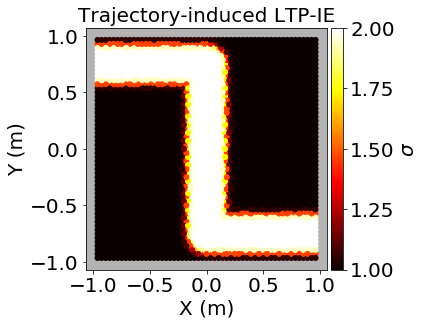

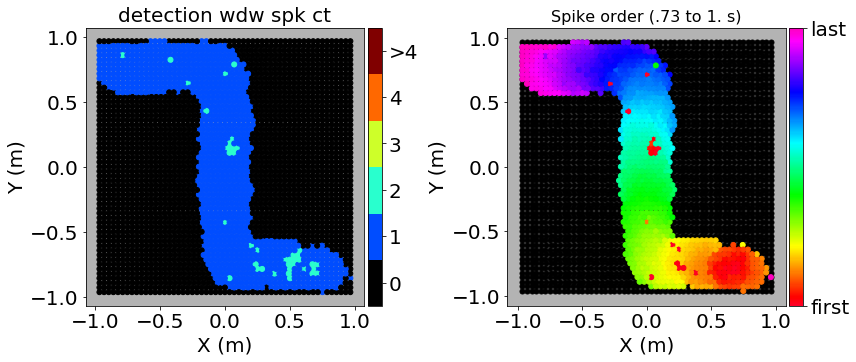

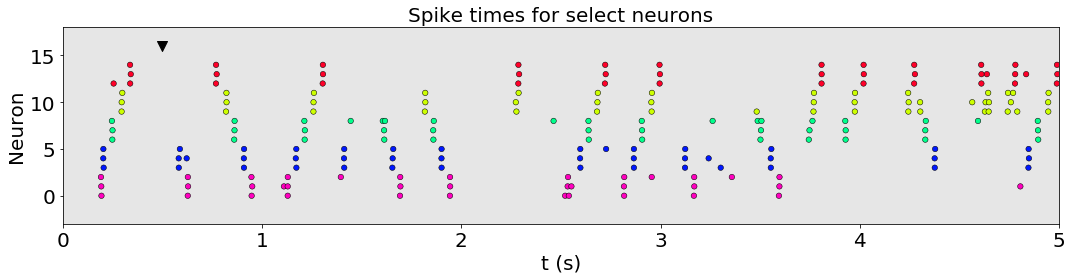

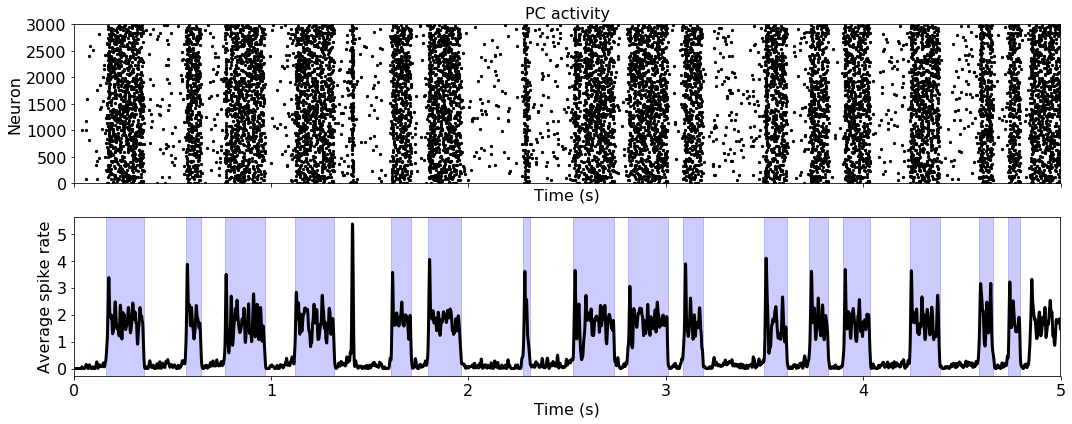

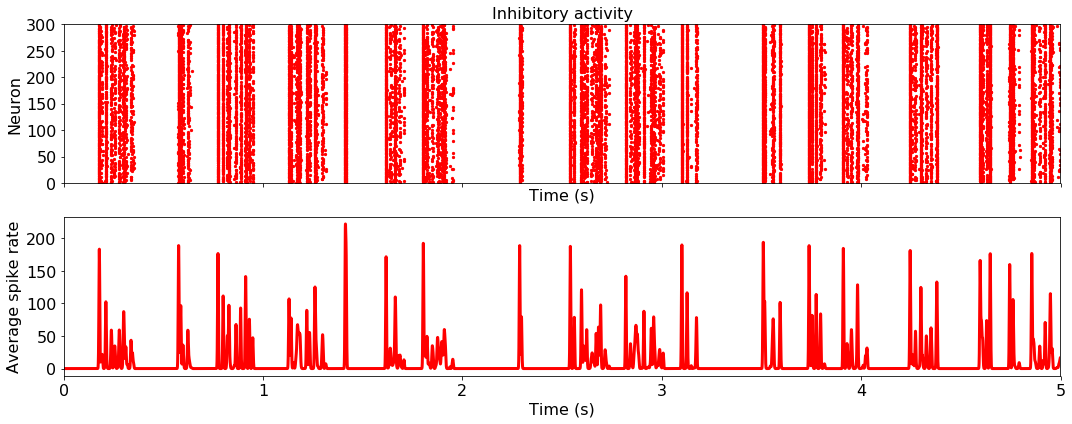

In [5]:
# get metrics
## candidate event boundaries
starts, ends = get_evts(rslt, A_PARAMS)

## event features
for e_ctr, (start, end) in enumerate(zip(starts, ends)):
    
    # trj-PC and non-trj-PC firing rates during candidate events
    fr_trj, fr_ntrj = get_fr_trj_ntrj(rslt, start, end, A_PARAMS)
    
    # pos-t rank correlation ("one-way-ness")
    pos_t_corr = get_pos_t_corr(rslt, start, end, A_PARAMS)
    
    print('Event', e_ctr)
    print('  fr_trj = ', fr_trj, 'Hz')
    print('  fr_ntrj = ', fr_ntrj, 'Hz')
    print('  pos-t corr = ', pos_t_corr)
    
# position

# make plots
## full replay
ax = plot.heat_maps(rslt, cmap='gist_rainbow', epoch=(.73, 1.))[1][1][1]
ax.set_title('Spike order (.73 to 1. s)', fontsize=16)

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    ],
    colors=np.linspace(1, 0, 5),
    cmap='gist_rainbow',
    nearest=3,
    epoch='replay',
    trg_plt=[(16, 'v'), (-1.5, '^'), (16, 'v'), (-1.5, '^')],
    y_lim=(-3, 18),
    y_ticks=np.linspace(0, 15, 4),
    title='Spike times for select neurons',
)

axs = plot.plot_pc(rslt, smoothness=A_PARAMS['SMOOTH_FR'])[1]
# plot event detections
for start, end in zip(starts, ends):
    axs[1].axvspan(start, end, color='b', alpha=0.2)
    
plot.plot_inh(rslt, smoothness=A_PARAMS['SMOOTH_FR']);

### Blowup test

In [6]:
m_params = copy(M_PARAMS)
s_params = copy(S_PARAMS)

m_params['W_PC_INH'] = 0
m_params['W_PC_PC'] = 0.03
s_params['RNG_SEED'] = 0
s_params['TRJ'] = [(-1, .75), (0, .75), (0, -.75), (1, -.75)]
s_params['schedule']['D_SMLN'] = 1

print('Running smln...')
rslt = smln.run(m_params, s_params)
print('Smln complete.')

Running smln...
Smln complete.


Event 0
  fr_trj =  11.038961038961043 Hz
  fr_ntrj =  10.963093510263324 Hz
  pos-t corr =  0.596089505545441
Event 1
  fr_trj =  9.417087542087538 Hz
  fr_ntrj =  9.237421383647794 Hz
  pos-t corr =  0.8677441206388863
Event 2
  fr_trj =  12.333702882483372 Hz
  fr_ntrj =  12.166359871145886 Hz
  pos-t corr =  -0.6996925974158957


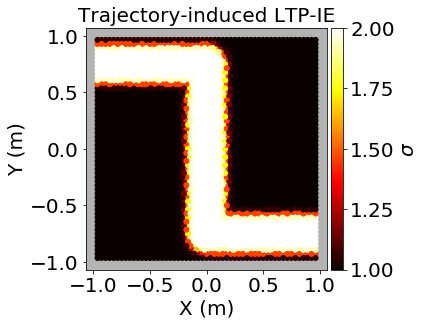

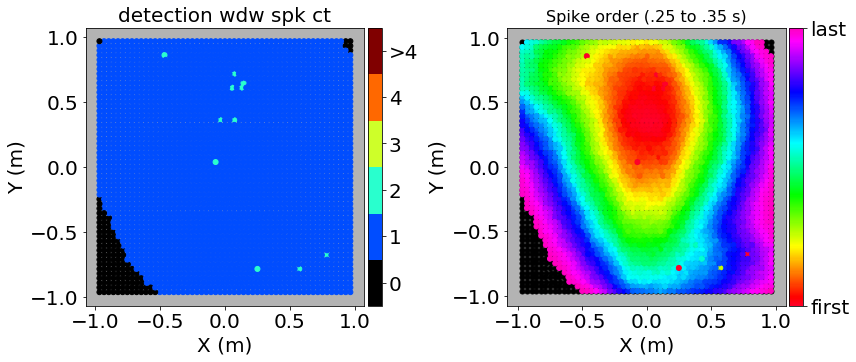

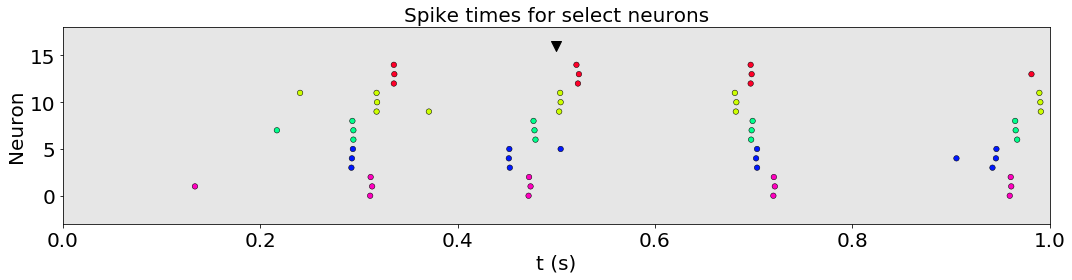

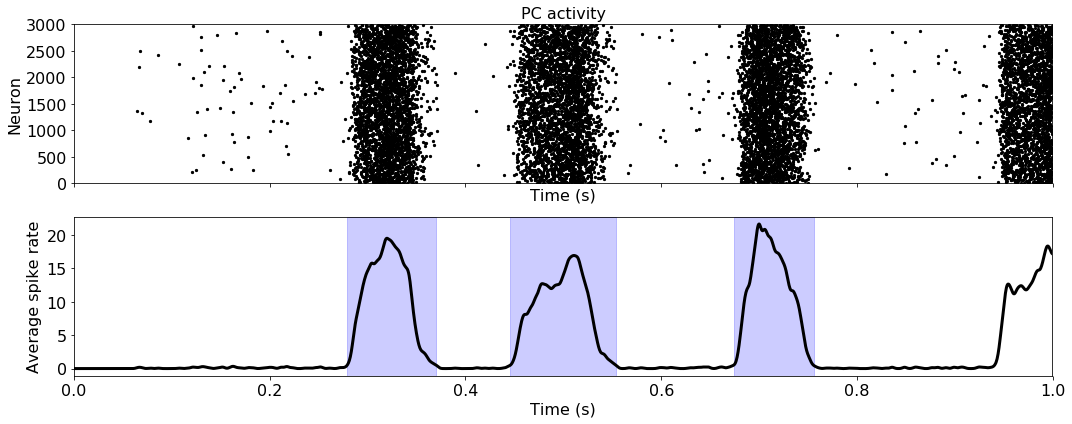

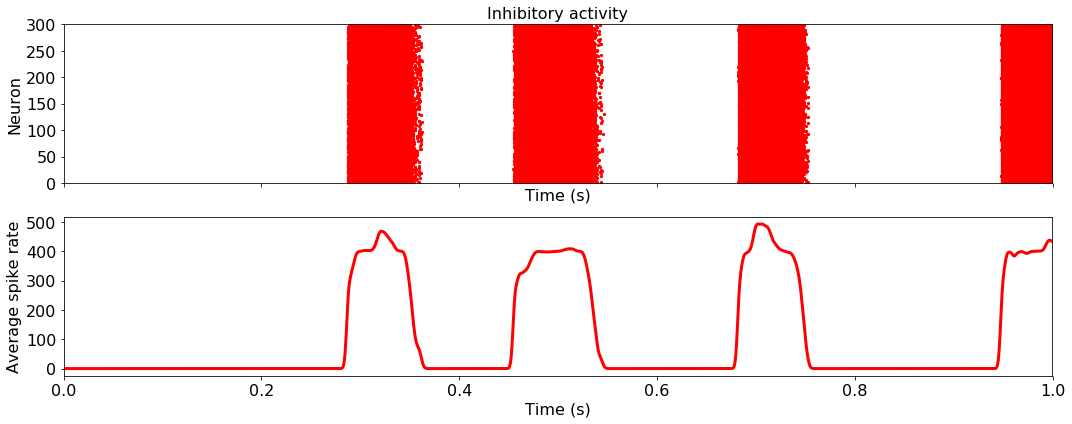

In [7]:
# get metrics
## candidate event boundaries
starts, ends = get_evts(rslt, A_PARAMS)

## event features
for e_ctr, (start, end) in enumerate(zip(starts, ends)):
    
    # trj-PC and non-trj-PC firing rates during candidate events
    fr_trj, fr_ntrj = get_fr_trj_ntrj(rslt, start, end, A_PARAMS)
    
    # pos-t rank correlation ("one-way-ness")
    pos_t_corr = get_pos_t_corr(rslt, start, end, A_PARAMS)
    
    print('Event', e_ctr)
    print('  fr_trj = ', fr_trj, 'Hz')
    print('  fr_ntrj = ', fr_ntrj, 'Hz')
    print('  pos-t corr = ', pos_t_corr)
    
# position

# make plots
## full replay
ax = plot.heat_maps(rslt, cmap='gist_rainbow', epoch=(.25, .35))[1][1][1]
ax.set_title('Spike order (.25 to .35 s)', fontsize=16)

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    ],
    colors=np.linspace(1, 0, 5),
    cmap='gist_rainbow',
    nearest=3,
    epoch='replay',
    trg_plt=[(16, 'v'), (-1.5, '^'), (16, 'v'), (-1.5, '^')],
    y_lim=(-3, 18),
    y_ticks=np.linspace(0, 15, 4),
    title='Spike times for select neurons',
)

axs = plot.plot_pc(rslt, smoothness=A_PARAMS['SMOOTH_FR'])[1]
# plot event detections
for start, end in zip(starts, ends):
    axs[1].axvspan(start, end, color='b', alpha=0.2)
    
plot.plot_inh(rslt, smoothness=A_PARAMS['SMOOTH_FR']);

### Fadeout test

In [8]:
m_params = copy(M_PARAMS)
s_params = copy(S_PARAMS)

m_params['W_PC_INH'] = 0
m_params['W_PC_PC'] = 0.01
s_params['RNG_SEED'] = 0
s_params['TRJ'] = [(-1, .75), (0, .75), (0, -.75), (1, -.75)]
s_params['schedule']['D_SMLN'] = 1

print('Running smln...')
rslt = smln.run(m_params, s_params)
print('Smln complete.')

Running smln...
Smln complete.


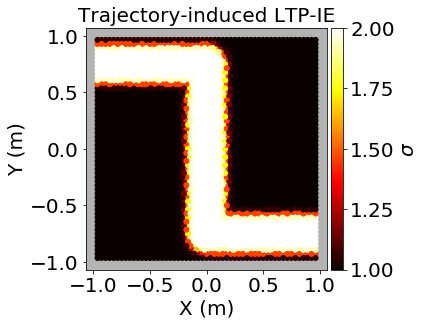

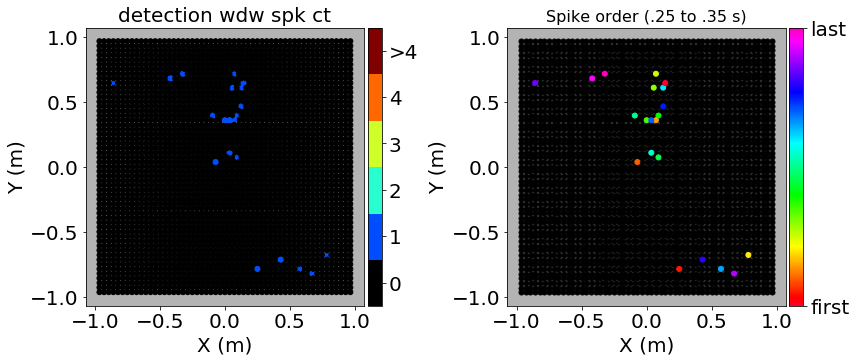

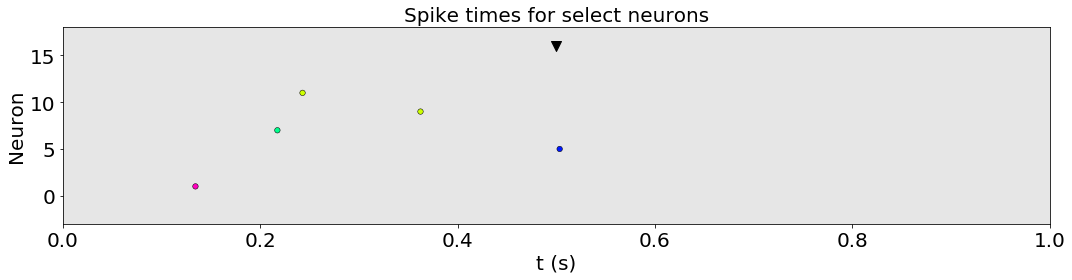

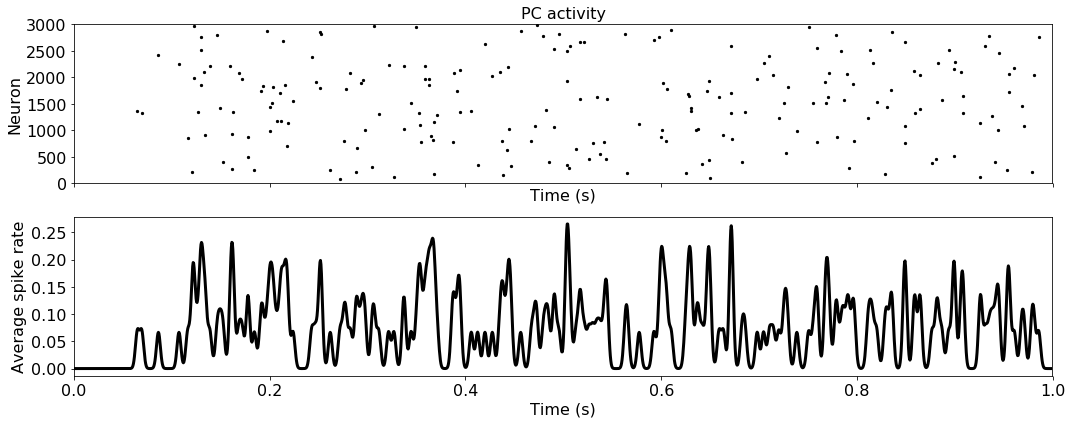

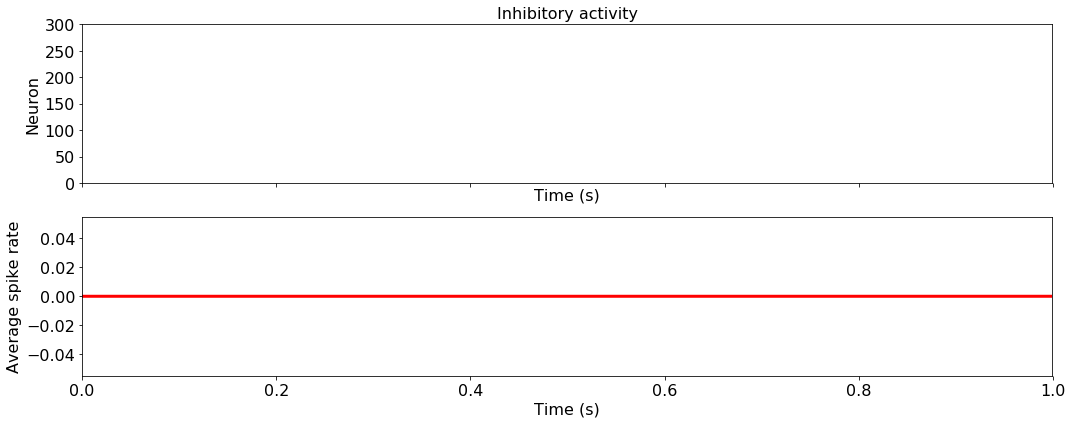

In [9]:
# get metrics
## candidate event boundaries
starts, ends = get_evts(rslt, A_PARAMS)

## event features
for e_ctr, (start, end) in enumerate(zip(starts, ends)):
    
    # trj-PC and non-trj-PC firing rates during candidate events
    fr_trj, fr_ntrj = get_fr_trj_ntrj(rslt, start, end, A_PARAMS)
    
    # pos-t rank correlation ("one-way-ness")
    pos_t_corr = get_pos_t_corr(rslt, start, end, A_PARAMS)
    
    print('Event', e_ctr)
    print('  fr_trj = ', fr_trj, 'Hz')
    print('  fr_ntrj = ', fr_ntrj, 'Hz')
    print('  pos-t corr = ', pos_t_corr)
    
# position

# make plots
## full replay
ax = plot.heat_maps(rslt, cmap='gist_rainbow', epoch=(.25, .35))[1][1][1]
ax.set_title('Spike order (.25 to .35 s)', fontsize=16)

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    ],
    colors=np.linspace(1, 0, 5),
    cmap='gist_rainbow',
    nearest=3,
    epoch='replay',
    trg_plt=[(16, 'v'), (-1.5, '^'), (16, 'v'), (-1.5, '^')],
    y_lim=(-3, 18),
    y_ticks=np.linspace(0, 15, 4),
    title='Spike times for select neurons',
)

axs = plot.plot_pc(rslt, smoothness=A_PARAMS['SMOOTH_FR'])[1]
# plot event detections
for start, end in zip(starts, ends):
    axs[1].axvspan(start, end, color='b', alpha=0.2)
    
plot.plot_inh(rslt, smoothness=A_PARAMS['SMOOTH_FR']);